# SpringBoard Capstone 2: Chest X-Ray Classification

### Importing relevant packages

In [48]:
!pip install seaborn

In [49]:

import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline


## Table of contents

## Importing data 

In [50]:
#import image data and associated information
df = pd.read_csv('../data/Data_Entry_2017.csv')

# take a preliminary look at the data and column information
print(df.columns)
print(df.shape)
df.head()

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')
(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [51]:
# associate the relevant file path with the image label for specific file viewing
image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../data', 'images*', '*.png'))}

# number of images found v. the number of entries in the csv
print('Scans found:', len(image_paths), ', Total Headers', df.shape[0])

# import the specific file path
df['path'] = df['Image Index'].map(image_paths.get)

#  remove the 'Y' from the age column
# df['Patient Age'] = df['Patient Age'].map(lambda x: int(x[:-1]))

df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70965,00017504_043.png,Infiltration,43,17504,12,F,AP,2500,2048,0.168,0.168,NaN,../data/images/00017504_043.png
78299,00019210_002.png,No Finding,2,19210,55,M,AP,2500,2048,0.168,0.168,NaN,../data/images/00019210_002.png
12046,00003140_002.png,No Finding,2,3140,30,F,AP,2500,2048,0.168,0.168,NaN,../data/images/00003140_002.png


In [52]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [53]:
# check for missing data
print('number of patients: ', df['Patient ID'].nunique())
print('number of scans:', df['Image Index'].nunique())
# print('number of pt visits: ', df[''])
print(df.isnull().any())

number of patients:  30805
number of scans: 112120
Image Index                    False
Finding Labels                 False
Follow-up #                    False
Patient ID                     False
Patient Age                    False
Patient Gender                 False
View Position                  False
OriginalImage[Width            False
Height]                        False
OriginalImagePixelSpacing[x    False
y]                             False
Unnamed: 11                     True
path                           False
dtype: bool


In [54]:
#cleaning up the columns
#df.drop(['Follow-up #', 'OriginalImageWidth', 
#         'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y'], axis=1, inplace=True)
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../data/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../data/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../data/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../data/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../data/images/00000003_000.png


In [55]:
# check proportions of xray view type
print(df['View Position'].value_counts())

PA    67310
AP    44810
Name: View Position, dtype: int64


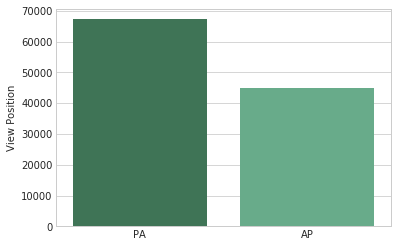

In [56]:
x = ['PA', 'AP']
y = df['View Position'].value_counts()
sns.barplot(x, y, palette="BuGn_d");

In [57]:
# check the unique labels
print(df['Finding Labels'].unique())

['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Hernia' 'Hernia|Infiltration' 'Mass|Nodule' 'Infiltration'
 'Effusion|Infiltration' 'Nodule' 'Emphysema' 'Effusion' 'Atelectasis'
 'Effusion|Mass' 'Emphysema|Pneumothorax' 'Pleural_Thickening'
 'Effusion|Emphysema|Infiltration|Pneumothorax'
 'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax'
 'Effusion|Pneumonia|Pneumothorax' 'Pneumothorax'
 'Effusion|Infiltration|Pneumothorax' 'Infiltration|Mass'
 'Infiltration|Mass|Pneumothorax' 'Mass'
 'Cardiomegaly|Infiltration|Mass|Nodule'
 'Cardiomegaly|Effusion|Emphysema|Mass'
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax' 'Emphysema|Mass'
 'Emphysema|Mass|Pneumothorax' 'Atelectasis|Pneumothorax'
 'Cardiomegaly|Emphysema|Pneumothorax' 'Mass|Pleural_Thickening'
 'Cardiomegaly|Mass|Pleural_Thickening' 'Effusion|Infiltration|Nodule'
 'Atelectasis|Effusion|Pleural_Thickening' 'Fibrosis|Infiltration'
 'Fibrosis|Infiltration|Pleural_Thickening' 'Fibrosis'
 '

In [58]:
# check the number of each label
df['Finding Labels'].value_counts()

No Finding                                                                          60361
Infiltration                                                                         9547
Atelectasis                                                                          4215
Effusion                                                                             3955
Nodule                                                                               2705
Pneumothorax                                                                         2194
Mass                                                                                 2139
Effusion|Infiltration                                                                1603
Atelectasis|Infiltration                                                             1350
Consolidation                                                                        1310
Atelectasis|Effusion                                                                 1165
Pleural_Th

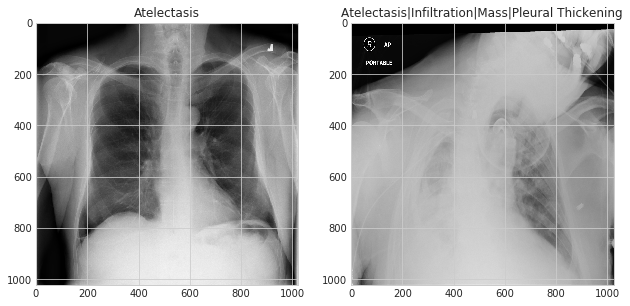

In [59]:
# visualizing some of the images
images = ['../data/images/00000030_001.png', '../data/images/00000248_020.png']

plt.figure(figsize=(16,16))
plt.subplot(131)
plt.title('Atelectasis')
plt.imshow(cv2.imread(images[0]))


plt.subplot(132)
plt.title('Atelectasis|Infiltration|Mass|Pleural Thickening')
plt.imshow(cv2.imread(images[1])) 

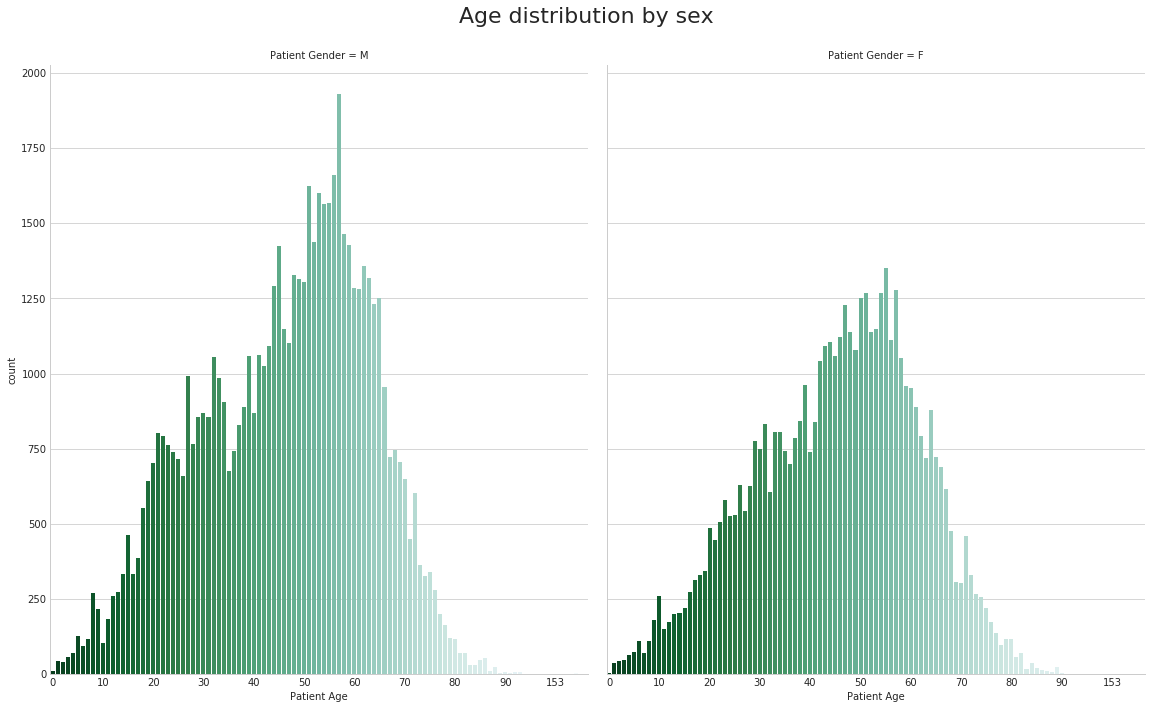

In [60]:
# disteribution of age by gender
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=df, kind="count",size=10, aspect=0.8,palette="BuGn_r");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex',fontsize=22);
g.fig.subplots_adjust(top=.9)

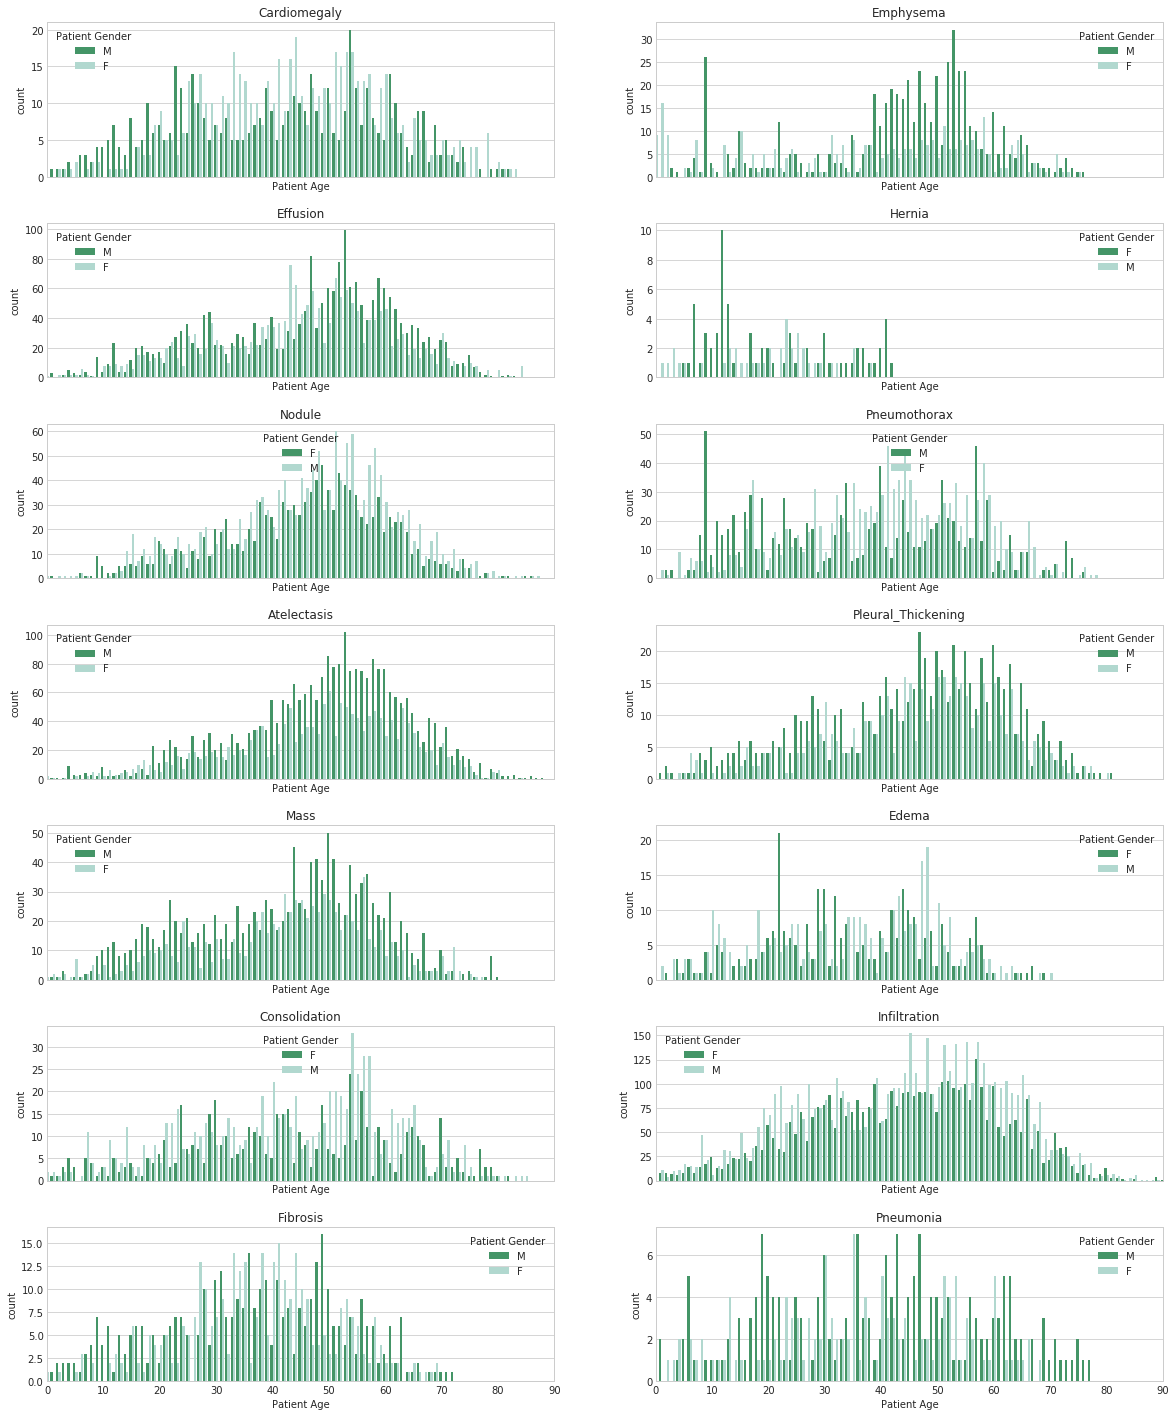

In [61]:
# looking at the distribution of age by gender and pathology to check for any magor underlying bias
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

f, axarr = plt.subplots(7, 2, sharex=True,figsize=(20, 25))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df[df['Finding Labels']==pathology], palette="BuGn_r", ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


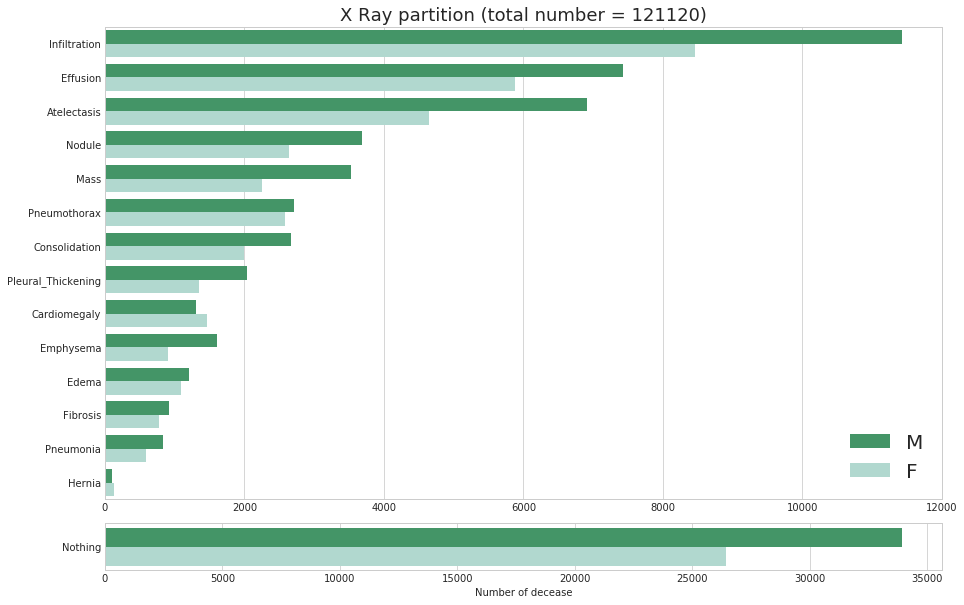

In [62]:
# check the overall distribution of label types
import matplotlib.gridspec as gridspec

#drop unused columns
labels = df[['Finding Labels', 'Patient ID','Patient Age','Patient Gender']]

#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening',
                  'Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])

data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')

data1 = data1.loc[data1.Count>0]

g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, palette="BuGn_r", order = data1['Category'].value_counts().index)

ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')

data2 = data2.loc[data2.Count>0]

g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2, palette="BuGn_r")

ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

## Images

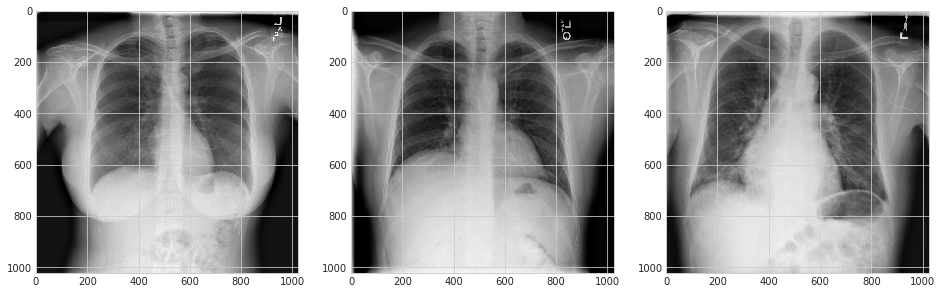

In [63]:
import random
import cv2
from PIL import Image

images = []
for filename in glob('../data/images/**/*.png', recursive=True):
    images.append(filename)

'''im = Image.open('../data/images/00022416_006.png')
width, height = im.size # returns (width, height) tuple
print('Width: ', width, 'Height: ', height)'''

images = []
for filename in glob('../data/images/**/*.png', recursive=True):
    images.append(filename)

r = random.sample(images, 3)

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]));  

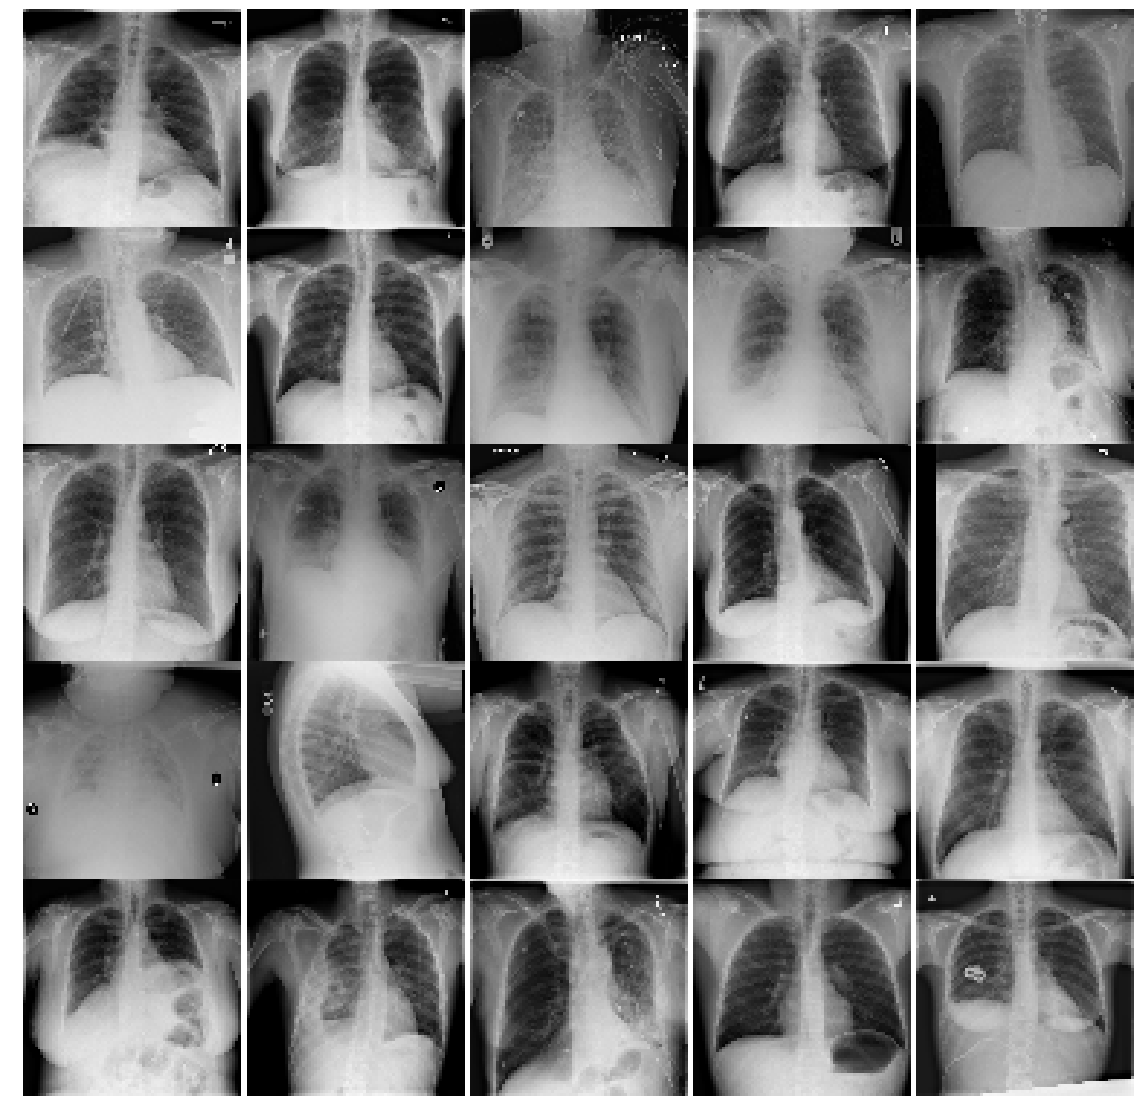

In [64]:
# Plot Multiple Images
xrays = glob('/data/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in xrays[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (75, 75)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [65]:
duplicates = []

In [66]:
def add_to_duplicates(d):
    labels = d['Finding Labels'].split('|')[1:]
    for label in labels:
        e = d.copy()
        e['label'] = label
        duplicates.append(e)

for i, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    if len(labels) > 1:
        add_to_duplicates(row.to_dict())

In [67]:
dup = pd.DataFrame(duplicates)

In [68]:
dup.drop('Finding Labels', axis='columns', inplace=True)

In [69]:
dup.head()

,Follow-up #,Height],Image Index,OriginalImagePixelSpacing[x,OriginalImage[Width,Patient Age,Patient Gender,Patient ID,Unnamed: 11,View Position,label,path,y]
0,1,2729,00000001_001.png,0.143,2894,58,M,1,NaN,PA,Emphysema,../data/images/00000001_001.png,0.143
1,2,2048,00000001_002.png,0.168,2500,58,M,1,NaN,PA,Effusion,../data/images/00000001_002.png,0.168
2,3,2991,00000003_003.png,0.143,2698,76,F,3,NaN,PA,Infiltration,../data/images/00000003_003.png,0.143
3,0,2048,00000004_000.png,0.168,2500,82,M,4,NaN,AP,Nodule,../data/images/00000004_000.png,0.168
4,7,2681,00000005_007.png,0.143,2566,70,F,5,NaN,PA,Infiltration,../data/images/00000005_007.png,0.143


In [70]:
dup.label.unique()

array(['Emphysema', 'Effusion', 'Infiltration', 'Nodule', 'Mass',
       'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Cardiomegaly',
       'Edema', 'Consolidation', 'Fibrosis', 'Hernia', 'Atelectasis'],
      dtype=object)

In [71]:
mask = []
for index, row in df.iterrows():
    labels = row['Finding Labels']
    num_labels = labels.split('|')
    if len(num_labels) > 1:
        mask.append(index)

In [72]:
df.drop(df.index[mask], inplace=True)
df.shape

(91324, 13)

In [73]:
df = df.rename(columns={'Finding Labels': 'label'})

In [74]:
df.head()

,Image Index,label,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../data/images/00000001_000.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../data/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../data/images/00000003_000.png
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,../data/images/00000003_001.png
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN,../data/images/00000003_002.png


In [75]:
# df.drop('Finding Labels', axis='columns', inplace=True)

In [76]:
df_labels = pd.concat([df, dup])

In [77]:
df_labels.sample(5)

,Follow-up #,Height],Image Index,OriginalImagePixelSpacing[x,OriginalImage[Width,Patient Age,Patient Gender,Patient ID,Unnamed: 11,View Position,label,path,y]
100758,15,2021,00026753_015.png,0.194311,2021,50,M,26753,NaN,PA,Effusion,../data/images/00026753_015.png,0.194311
15330,24,2048,00015658_024.png,0.168000,2500,53,M,15658,NaN,AP,Infiltration,../data/images/00015658_024.png,0.168000
15829,0,2991,00004184_000.png,0.143000,2558,30,F,4184,NaN,PA,No Finding,../data/images/00004184_000.png,0.143000
911,1,2048,00001052_001.png,0.168000,2500,40,M,1052,NaN,PA,Infiltration,../data/images/00001052_001.png,0.168000
408,3,2021,00000344_003.png,0.194311,2021,33,M,344,NaN,PA,Effusion,../data/images/00000344_003.png,0.194311


In [78]:
df_labels['label'].unique()

array(['Cardiomegaly', 'No Finding', 'Hernia', 'Infiltration', 'Nodule',
       'Emphysema', 'Effusion', 'Atelectasis', 'Pleural_Thickening',
       'Pneumothorax', 'Mass', 'Fibrosis', 'Consolidation', 'Edema',
       'Pneumonia'], dtype=object)

In [79]:
# ensuring that the shape of the newly added information makes since
df.shape

(91324, 13)

In [80]:
dup.shape

(29417, 13)

In [81]:
df_labels.shape

(120741, 13)

In [82]:
dup.shape[0] + df.shape[0]

120741

In [83]:
categories = df_labels['label'].value_counts()

In [84]:
# number of distinct classes that we are dealing with for the classification problem
len(categories.to_dict())

15

In [85]:
# save the newly cleaned and rearranged and cleaned data entries for easy future use
df_labels.to_csv('clean_data.csv', index=False)